In [3]:
import pandas as pd
import numpy as np

In [4]:
import numpy as np
import pandas as pd

def generate_ar1_data(N, T, rho, mean=0, std_dev=1):
    # Generate random white noise
    white_noise = np.random.normal(mean, std_dev, size=(N, T))

    # Initialize the array to store the data
    data = np.zeros((N, T))

    # Generate the AR(1) process data
    for i in range(N):
        for t in range(T):
            if t == 0:
                data[i, t] = white_noise[i, t]
            else:
                data[i, t] = rho * data[i, t - 1] + white_noise[i, t]

    # Create a DataFrame with column names as time periods
    df = pd.DataFrame(data, columns=[f'{t}' for t in range(T)])

    # Add a new 'state' column with random numbers between 1 and N
    df['state'] = np.arange(1, N + 1)

    melted_df = pd.melt(df, id_vars=['state'], var_name='time', value_name='value')
    
    
    data = melted_df.copy()

    data['time'] = data['time'].astype(int)
    # Create state dummy variables
    state_dummies = pd.get_dummies(data['state'], prefix='state', drop_first = True)

    # Convert state dummy variables to int
    state_dummies = state_dummies.astype(int)

    # Create time dummy variables
    time_dummies = pd.get_dummies(data['time'].astype(int), prefix='time', drop_first = True)

    # Convert time dummy variables to int
    time_dummies = time_dummies.astype(int)

    # Concatenate the dummy variables with the original DataFrame
    data = pd.concat([data, state_dummies, time_dummies], axis=1)

    return data

# Example usage:
N = 50
T = 20
rho = 0.5  # Set your desired autoregressive coefficient
generated_data = generate_ar1_data(N, T, rho)



In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

np.random.seed(42)

beta1_estimates = []
reject_count = 0  # Counter for the number of rejections
alpha = 0.05  # Significance level

bias_values = []
squared_error_values = []
N = 50
T = 20
rho = 0.8
true_beta1_value = 0 


for _ in range(1000):
    data = generate_ar1_data( N, T, rho)
    states = data['state'].unique()

    # Randomly select half of the states to be in the treatment group
    
    treatment_states = np.random.choice(states, size=len(states)//2, replace=False)

    # Assign treatment year to each treatment state, staggered between 1985 and 1995
    treatment_years = np.random.choice(range(5, 15), size=len(treatment_states), replace=True)
    state_to_treatment_year = dict(zip(treatment_states, treatment_years))

    # Add a treatment column to the DataFrame
    data['TREATMENT'] = data.apply(lambda x: 1 if x['state'] in treatment_states and x['time'] >= state_to_treatment_year[x['state']] else 0, axis=1)

    # Step 3: Perform the OLS regression
    X = data[['TREATMENT', 'state_2', 'state_3', 'state_4', 'state_5',
       'state_6', 'state_7', 'state_8', 'state_9', 'state_10', 'state_11',
       'state_12', 'state_13', 'state_14', 'state_15', 'state_16', 'state_17',
       'state_18', 'state_19', 'state_20', 'state_21', 'state_22', 'state_23',
       'state_24', 'state_25', 'state_26', 'state_27', 'state_28', 'state_29',
       'state_30', 'state_31', 'state_32', 'state_33', 'state_34', 'state_35',
       'state_36', 'state_37', 'state_38', 'state_39', 'state_40', 'state_41',
       'state_42', 'state_43', 'state_44', 'state_45', 'state_46', 'state_47',
       'state_48', 'state_49', 'state_50', 'time_1', 'time_2', 'time_3',
       'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9', 'time_10',
       'time_11', 'time_12', 'time_13', 'time_14', 'time_15', 'time_16',
       'time_17', 'time_18', 'time_19']] # plus any other control variables
    X = sm.add_constant(X)
    Y = data['value'] # Replace 'outcome' with your dependent variable
    model = sm.OLS(Y, X).fit()

    bias = model.params['TREATMENT'] - true_beta1_value
    
    bias_values.append(bias)

    squared_error = (model.params['TREATMENT'] - true_beta1_value) ** 2
    
    # Check if null hypothesis for beta1 is rejected
    if model.pvalues['TREATMENT'] < alpha:
        reject_count += 1



type1_error = reject_count / 1000
average_bias = np.mean(bias_values)
average_mse = np.mean(squared_error)


# Print the number of rejections
print(f"Number of times null hypothesis is rejected: {reject_count} out of 1000 simulations")
print(f"Type 1 Error: {type1_error}")
print(f"Bias for Coefficient of Treatment (True Value = {true_beta1_value}): {average_bias}")
print(f"Average MSE for Coefficient of Treatment (True Value = {true_beta1_value}): {average_mse}")

Number of times null hypothesis is rejected: 352 out of 1000 simulations
Type 1 Error: 0.352
Bias for Coefficient of Treatment (True Value = 0): -0.0058584810468833345
Average MSE for Coefficient of Treatment (True Value = 0): 0.017478656417037653


c:\Users\Biswajit Palit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


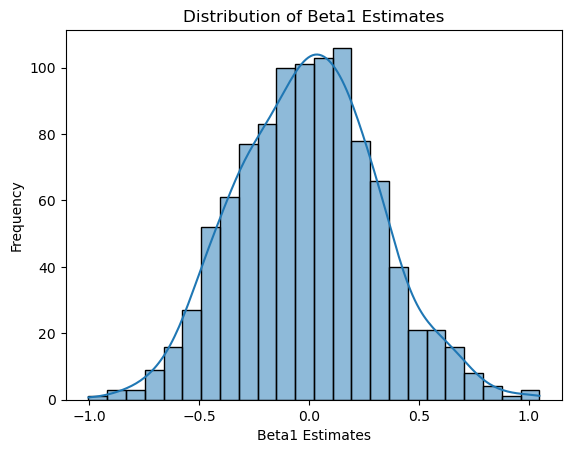

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(bias_values, kde=True)
plt.xlabel('Beta1 Estimates')
plt.ylabel('Frequency')
plt.title('Distribution of Beta1 Estimates')
plt.show()